In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.signal import hilbert, savgol_filter, find_peaks
from scipy.interpolate import interp1d
from symreg import Promising_solution, Solution, Problem, create_arbitrary_constraint
import sympy as sp
from typing import Tuple, List
from scipy.optimize import curve_fit 
from scipy.special import airy
import scipy

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


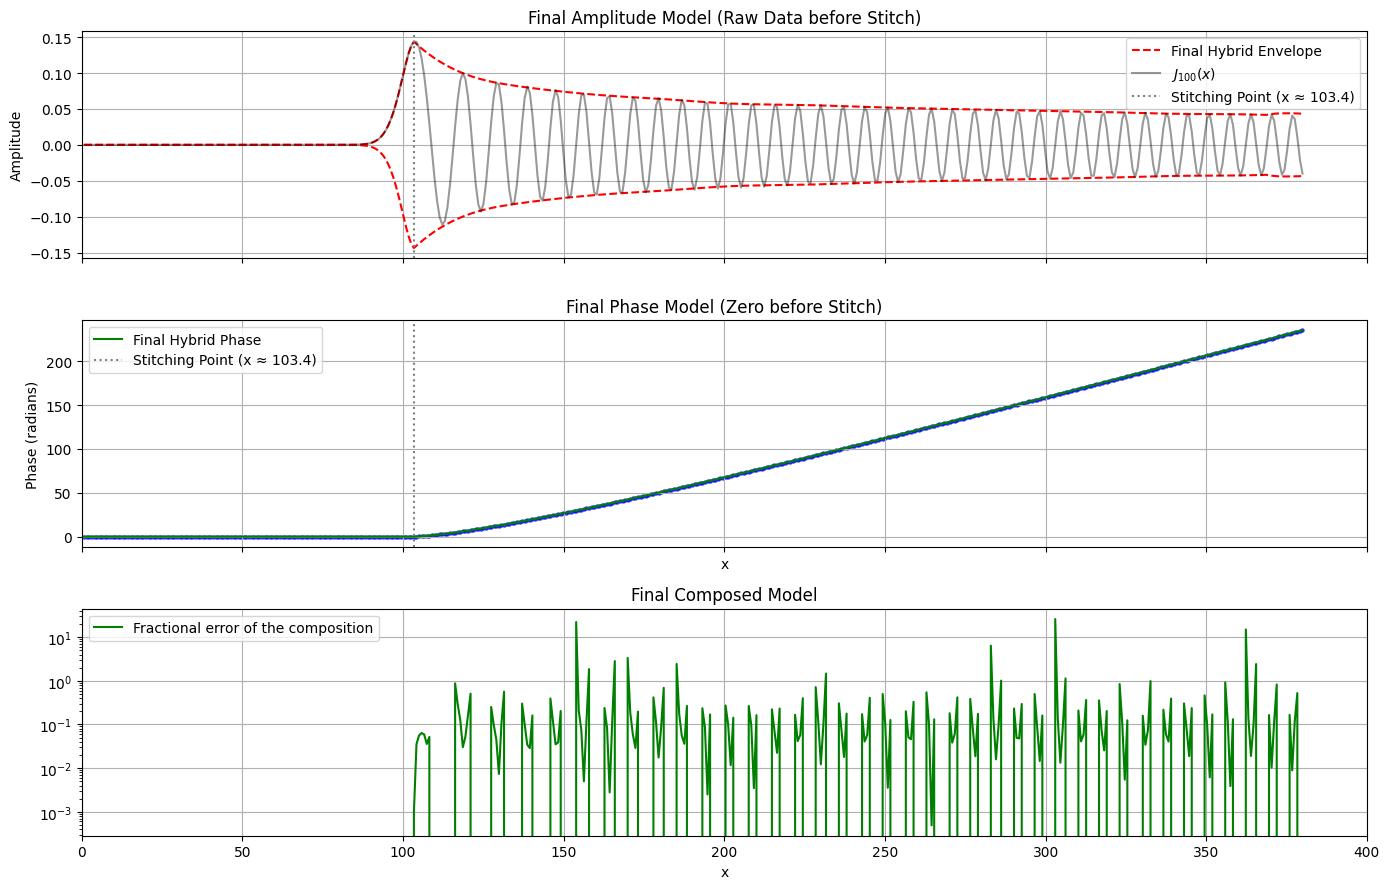

In [2]:


# --- Step 1: Initial Setup and Finding Landmarks ---
order = 100
x_full = np.linspace(0, 400, 500)
y_full = special.jv(order, x_full)

# Find peaks in the oscillatory region to define our stitching point
x_osc_region = x_full[x_full > 90]
y_osc_region = y_full[x_full > 90]
peaks_indices, _ = find_peaks(y_osc_region, distance=10)
x_peaks = x_osc_region[peaks_indices]
y_peaks = y_osc_region[peaks_indices]

# The stitching point is the first peak
x_stitch = x_peaks[0]


# --- Step 2: Create the "Right-Side" Models (for x >= x_stitch) ---
# This is our data-driven model for the main oscillatory region

# --- Amplitude Model (Smoothed Spline) ---
spline_func = interp1d(x_peaks, y_peaks, kind='cubic', bounds_error=False, fill_value=0)
x_right = x_full[x_full >= x_stitch]
amplitude_right = spline_func(x_right)
amplitude_right = savgol_filter(amplitude_right, 71, 3)
amplitude_right[amplitude_right < 0] = 0

# --- Phase Model (Hilbert Transform) ---
x_phase_calc_region = x_full[x_full >= 95]
y_phase_calc_region = y_full[x_full >= 95]
dt = x_phase_calc_region[1] - x_phase_calc_region[0]; pad_width = int(len(y_phase_calc_region) * 0.1); fit_points=50
y_padded_start = np.pad(y_phase_calc_region, (pad_width, 0), mode='symmetric')[:pad_width]
end_coeffs = np.polyfit(x_phase_calc_region[-fit_points:], y_phase_calc_region[-fit_points:], 1); end_poly = np.poly1d(end_coeffs)
x_end_pad = np.arange(1, pad_width + 1) * dt + x_phase_calc_region[-1]; y_end_pad = end_poly(x_end_pad)
y_padded = np.concatenate([y_padded_start, y_phase_calc_region, y_end_pad])
analytic_signal = hilbert(y_padded)[pad_width:-pad_width]
phase_calculated = np.unwrap(np.angle(analytic_signal))
phase_calculated = savgol_filter(phase_calculated, 41, 3)
phase_interp_func = interp1d(x_phase_calc_region, phase_calculated, kind='cubic', fill_value='extrapolate')
phase_right = phase_interp_func(x_right)
phase_right -= phase_right[0]


# --- NEW, SIMPLIFIED: Step 3: Create the "Left-Side" Models (for x < x_stitch) ---

# --- Amplitude Model: Use the raw Bessel function data ---
x_left = x_full[x_full < x_stitch]
# The "envelope" here is simply the absolute value of the true function
amplitude_left = np.abs(special.jv(order, x_left))

# --- Phase Model: Explicitly set to zero ---
phase_left = np.zeros_like(x_left)


# --- Step 4: Stitch and Trim the Final Model ---
amplitude_full = np.concatenate([amplitude_left, amplitude_right])
phase_full = np.concatenate([phase_left, phase_right])

# Apply final trim to the end of the arrays
final_trim_percent_end = 5.0 
trim_points = int(len(x_full) * final_trim_percent_end / 100)
x_final = x_full[:-trim_points][1:]
y_final = y_full[:-trim_points][1:]
amplitude_final = amplitude_full[:-trim_points][1:]
phase_final = phase_full[:-trim_points][1:]


# --- Step 5: Final Visualization ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# Plot 1: Final Amplitude Envelope
ax1.plot(x_final, amplitude_final, label='Final Hybrid Envelope', color='red', linestyle='--')
ax1.plot(x_final, -amplitude_final, color='red', linestyle='--')
ax1.plot(x_final, y_final, color='k', alpha=0.4, label=f'$J_{{{order}}}(x)$')
ax1.axvline(x_stitch, color='gray', linestyle=':', label=f'Stitching Point (x ≈ {x_stitch:.1f})')
ax1.set_title('Final Amplitude Model (Raw Data before Stitch)')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# Plot 2: Final Phase
ax2.plot(x_final, phase_final, label='Final Hybrid Phase', color='green')
ax2.scatter(x_final, phase_final, s=5, color='blue', alpha=0.7)
ax2.axvline(x_stitch, color='gray', linestyle=':', label=f'Stitching Point (x ≈ {x_stitch:.1f})')
ax2.set_title('Final Phase Model (Zero before Stitch)')
ax2.set_ylabel('Phase (radians)')
ax2.set_xlabel('x')
ax2.legend()
ax2.grid(True)


# Plot 3: Plot final phase
ax3.plot(x_final, abs(amplitude_final * np.cos(phase_final) - special.jv(order, x_final))/special.jv(order, x_final) , label='Fractional error of the composition', color='green')
#ax3.plot(x_final, special.jv(order, x_final), label='Bessel function', color='orange')
ax3.set_title('Final Composed Model')
ax3.set_xlabel('x')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True)


plt.xlim(0, 400)
plt.tight_layout()
plt.show()

--- Running Uneven Sampler with 4-Region Strategy ---
Peak detected at x ≈ 103.85
Intensive peak zone: [83.85, 108.85]
Transition decay zone: [108.85, 158.85]
Sampling modes: Pre='linear', Peak='linear', Decay='linear', Post='log_decay'
New data has 403 points.
----------------------------
--- Running Uneven Sampler for Phase ---
Phase growth detected starting at x ≈ 103.85
New unevenly sampled phase data has 253 points.
----------------------------

--- Fitting Shifted and Scaled Function ---
8.45272575844283e-189 74.19889635998679
8.45272575844283e-189 74.19889635998679
Optimal parameters found:
8.45272575844283e-189 74.19889635998679
---------------------------------
[1.]


/tmp/ipykernel_242645/1516479263.py:279: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(reduction_func, x_final, amplitude_final, p0=initial_guesses, maxfev=5000)


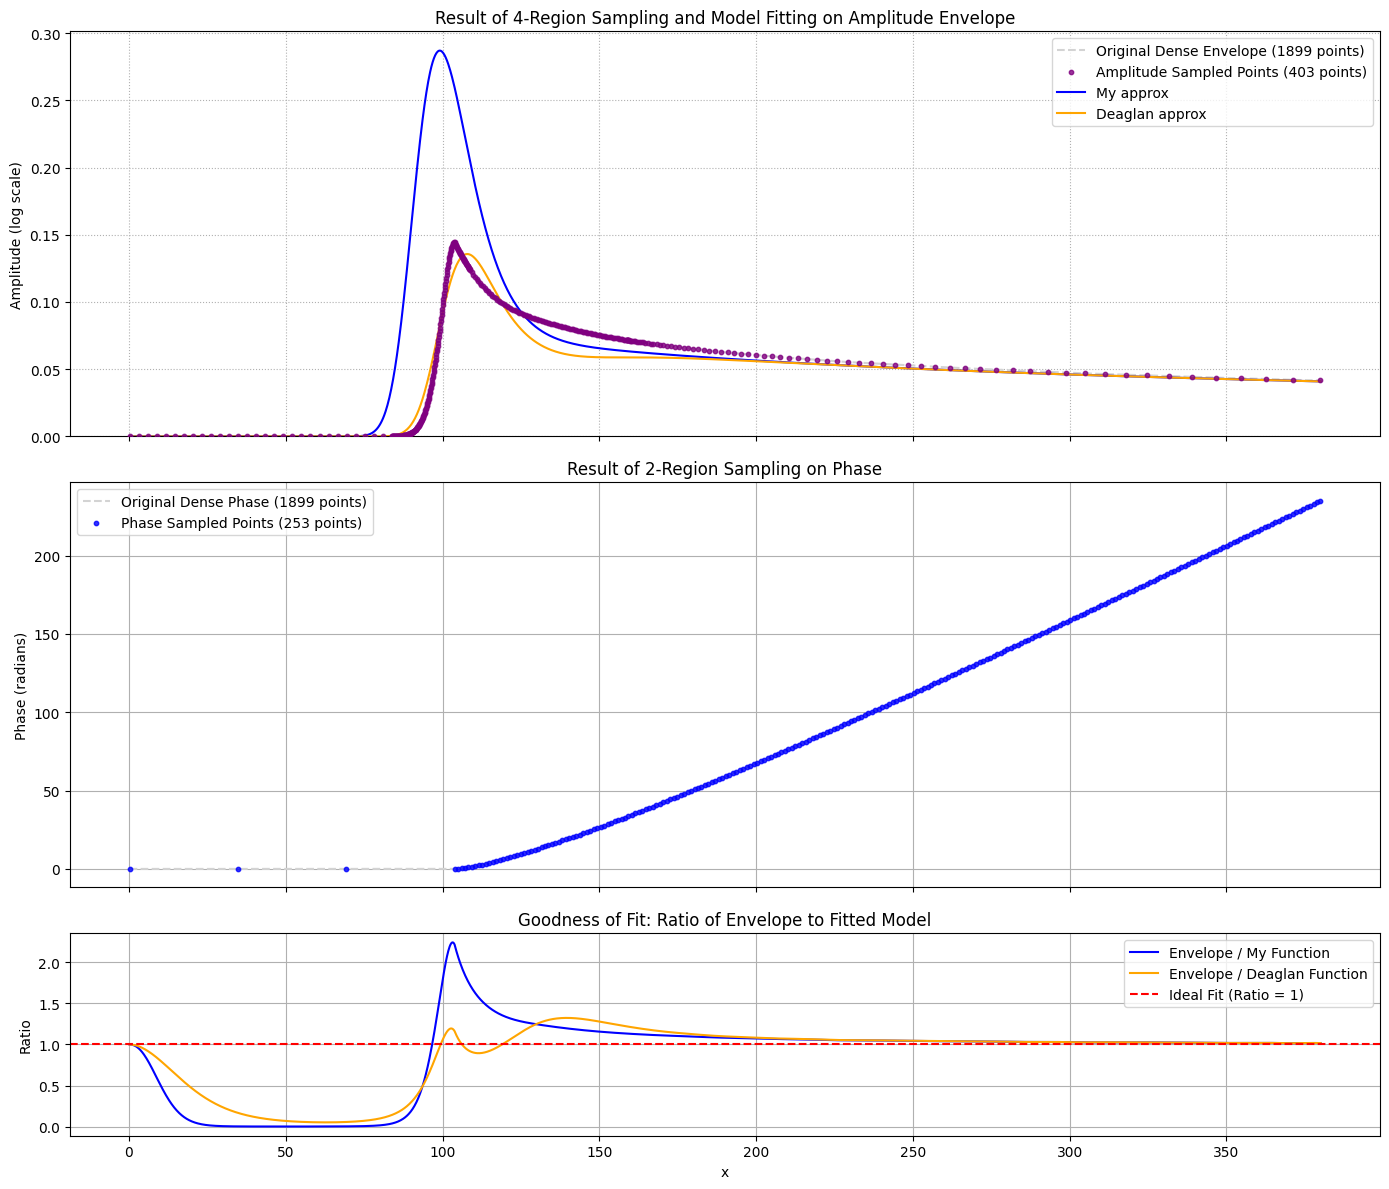

In [3]:
# --- Step 0A: The Uneven Sampler for Amplitude ---
def uneven_sampler(x_original: np.ndarray, y_original: np.ndarray,
                   n_pre_peak: int, n_peak_zone: int, n_decay_zone: int, n_post_peak: int,
                   peak_window_left: float = 10.0, peak_window_right: float = 10.0,
                   decay_zone_width: float = 50.0,
                   min_value: float = 1e-17,
                   sampling_modes: List[str] = ['linear', 'linear', 'linear', 'log_decay'],
                   log_decay_power: float = 2.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Resamples a 1D curve using a 4-region strategy with variable density and sampling modes.
    """
    print("--- Running Uneven Sampler with 4-Region Strategy ---")
    
    y_clipped = y_original#np.clip(y_original, min_value, None)
    peak_index = np.argmax(y_clipped)
    x_peak = x_original[peak_index]
    print(f"Peak detected at x ≈ {x_peak:.2f}")
    
    start_x = x_original[0]
    end_x = x_original[-1]
    
    peak_zone_start = max(start_x, x_peak - peak_window_left)
    peak_zone_end = min(end_x, x_peak + peak_window_right)
    decay_zone_end = min(end_x, peak_zone_end + decay_zone_width)
    print(f"Intensive peak zone: [{peak_zone_start:.2f}, {peak_zone_end:.2f}]")
    print(f"Transition decay zone: [{peak_zone_end:.2f}, {decay_zone_end:.2f}]")

    def generate_samples(start, end, num, mode):
        if start >= end: return np.array([])
        if start <= 0 and (mode == 'log' or mode == 'log_decay'): start = 1e-9

        if mode == 'log_decay':
            t = np.linspace(0, 1, num)
            t_transformed = t**log_decay_power
            log_start, log_end = np.log(start), np.log(end)
            log_samples = log_start + (log_end - log_start) * t_transformed
            return np.exp(log_samples)
        elif mode == 'log':
            return np.geomspace(start, end, num)
        else: # linear
            return np.linspace(start, end, num)

    x_samples_pre = generate_samples(start_x, peak_zone_start, n_pre_peak, sampling_modes[0])
    x_samples_peak = generate_samples(peak_zone_start, peak_zone_end, n_peak_zone, sampling_modes[1])
    x_samples_decay = generate_samples(peak_zone_end, decay_zone_end, n_decay_zone, sampling_modes[2])
    x_samples_post = generate_samples(decay_zone_end, end_x, n_post_peak, sampling_modes[3])
    
    x_sampled_uneven = np.concatenate([x_samples_pre, x_samples_peak, x_samples_decay, x_samples_post])
    x_sampled_uneven = np.unique(x_sampled_uneven)

    interp_func = interp1d(x_original, y_clipped, kind='linear', bounds_error=False, fill_value="extrapolate")
    y_sampled_uneven = interp_func(x_sampled_uneven)
    
    print(f"Sampling modes: Pre='{sampling_modes[0]}', Peak='{sampling_modes[1]}', Decay='{sampling_modes[2]}', Post='{sampling_modes[3]}'")
    print(f"New data has {len(x_sampled_uneven)} points.")
    print("----------------------------")

    # Return the full arrays, handling x=0 is done in the reduction_func
    return x_sampled_uneven, y_sampled_uneven


# --- Step 0B: The Uneven Sampler for Phase ---
def phase_sampler(x_original: np.ndarray, y_original: np.ndarray,
                  n_flat_zone: int, n_growth_zone: int,
                  growth_threshold: float = 0.1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Resamples a phase curve with a sparse flat section and a dense growth section.
    """
    print("--- Running Uneven Sampler for Phase ---")
    
    dy_dx = np.gradient(y_original, x_original)
    
    try:
        knee_index = np.where(dy_dx > growth_threshold)[0][0]
    except IndexError:
        knee_index = 0
        
    x_knee = x_original[knee_index]
    print(f"Phase growth detected starting at x ≈ {x_knee:.2f}")

    start_x = x_original[0]
    end_x = x_original[-1]

    x_samples_flat = np.linspace(start_x, x_knee, n_flat_zone)
    x_samples_growth = np.linspace(x_knee, end_x, n_growth_zone)
    
    x_sampled_uneven = np.concatenate([x_samples_flat, x_samples_growth])
    x_sampled_uneven = np.unique(x_sampled_uneven)

    interp_func = interp1d(x_original, y_original, kind='linear', bounds_error=False, fill_value="extrapolate")
    y_sampled_uneven = interp_func(x_sampled_uneven)
    
    print(f"New unevenly sampled phase data has {len(x_sampled_uneven)} points.")
    print("----------------------------")
    
    return x_sampled_uneven, y_sampled_uneven


# --- REVISED: Step 0C: Define the Shifted and Scaled Function to be Fitted ---
def reduction_func(x,theta0):
    """
    A function that takes the base asymptotic blending function and allows its
    peak to be scaled in height and shifted in position.
    - theta0: Scales the height of the peak (multiplicative factor).
    - theta1: Shifts the position of the peak (horizontal offset).
    - theta2: Adds a vertical offset to the entire function.
    """
    # Apply the horizontal shift to x
    x = np.asarray(x) 
    x = x
    
    # --- Base Asymptotic Form (calculated with the shifted x) ---
    alpha = order
    gamma = (1/special.gamma(order + 1)) * 2**(-alpha)
    beta = (np.sqrt(2/np.pi) * 1/gamma)**(1/(alpha + 1/2))
    denominator = (x**(-alpha) * (1 + (x/beta)**(alpha + 1/2)))
    base_function = (gamma / denominator)

    print(gamma, beta)

    # --- Apply Scaling and Offset ---
    return base_function 


def A_0_func(x):
    return (1/special.gamma(order + 1)) * (x/2)**order

def B_infty_func(x, order):
    return np.sqrt(2/(np.pi)) * (1/np.sqrt(x))
    

def smooth_transition(A, B, p, x, order):
    """
    Smoothly transitions between two functions A(x) and B(x) using a polynomial p(x).
    """
    return (A(x)**(-p) + B(x, order)**(-p))**(-1/p)

def E(A, B,x_0, x, order):
    s = 1/(1+np.exp(-0.2*(np.log(x)-np.log(x_0))))
    return A(x)**(1-s) * B(x, order)**(s)


def uniform_asymp(x, alpha, delta=1.0, p=1.0, eta=0.0, x_shift=0.0):
    """
    Uniform asymptotic approximation of J_alpha(x) with smooth peak control.

    Parameters
    ----------
    x : array_like
        Input values.
    alpha : float
        Order of the Bessel function.
    delta : float, optional
        Controls width of tanh transition (default 1.0).
    p : float, optional
        Exponent controlling sharpness of transition (default 1.0).
    eta : float, optional
        Flattening parameter to reduce overshoot at peak (default 0.0).
    x_shift : float, optional
        Shift of the peak along the x-axis (default 0.0).

    Returns
    -------
    f : array_like
        Approximated envelope of J_alpha(x).
    """
    x = np.asarray(x)
    
    # Low-x asymptotic
    f_low = (x/2)**alpha / special.gamma(alpha + 1)
    
    # High-x asymptotic
    f_high = np.sqrt(2/(np.pi*np.maximum(x, 1e-12)))  # avoid div by zero
    
    # Smooth transition with peak shift
    S = np.tanh(((x - x_shift)/alpha)**p / delta)
    
    # Log-space combination with flattening term
    logf = (1 - S)*np.log(np.maximum(f_low, 1e-300)) + S*np.log(np.maximum(f_high, 1e-300)) - eta*S*(1 - S)
    
    return np.exp(logf)


def myfun_full(x, alpha, xt, delta, ksi):
    explow = alpha
    exphigh = - 0.5
    log_Alow = - special.gammaln(alpha + 1) - alpha * np.log(2) + explow * np.log(xt)
    log_Ahigh = 0.5 * np.log(2 / np.pi) + exphigh * np.log(xt)

    u = x / xt
    
    S =np.tanh(u ** (ksi/delta))

    logf = log_Alow + S * (log_Ahigh - log_Alow) + explow * np.log(u) + delta * (exphigh - explow) * np.log(1 + u ** (1 / delta))
    f = np.exp(logf)

    return f



# --- Steps 1-4: Your original code to generate the final envelope and phase ---
order = 100
x_full = np.linspace(0, 400, 2000)
y_full = special.jv(order, x_full)

# (Code from previous steps remains the same here...)
x_osc_region = x_full[x_full > 90]
y_osc_region = y_full[x_full > 90]
peaks_indices, _ = find_peaks(y_osc_region, distance=10)
x_peaks = x_osc_region[peaks_indices]
y_peaks = y_osc_region[peaks_indices]
x_stitch = x_peaks[0]

spline_func = interp1d(x_peaks, y_peaks, kind='cubic', bounds_error=False, fill_value=0)
x_right = x_full[x_full >= x_stitch]
amplitude_right = spline_func(x_right)
amplitude_right = savgol_filter(amplitude_right, 71, 3)
amplitude_right[amplitude_right < 0] = 0

x_phase_calc_region = x_full[x_full >= 95]
y_phase_calc_region = y_full[x_full >= 95]
dt = x_phase_calc_region[1] - x_phase_calc_region[0]; pad_width = int(len(y_phase_calc_region) * 0.1); fit_points=50
y_padded_start = np.pad(y_phase_calc_region, (pad_width, 0), mode='symmetric')[:pad_width]
end_coeffs = np.polyfit(x_phase_calc_region[-fit_points:], y_phase_calc_region[-fit_points:], 1); end_poly = np.poly1d(end_coeffs)
x_end_pad = np.arange(1, pad_width + 1) * dt + x_phase_calc_region[-1]; y_end_pad = end_poly(x_end_pad)
y_padded = np.concatenate([y_padded_start, y_phase_calc_region, y_end_pad])
analytic_signal = hilbert(y_padded)[pad_width:-pad_width]
phase_calculated = np.unwrap(np.angle(analytic_signal))
phase_calculated = savgol_filter(phase_calculated, 41, 3)
phase_interp_func = interp1d(x_phase_calc_region, phase_calculated, kind='cubic', fill_value='extrapolate')
phase_right = phase_interp_func(x_right)
phase_right -= phase_right[0]

x_left = x_full[x_full < x_stitch]
amplitude_left = np.abs(special.jv(order, x_left))
phase_left = np.zeros_like(x_left)

amplitude_full = np.concatenate([amplitude_left, amplitude_right])
phase_full = np.concatenate([phase_left, phase_right])

final_trim_percent_end = 5.0 
trim_points = int(len(x_full) * final_trim_percent_end / 100)
x_final = x_full[:-trim_points][1:]
amplitude_final = amplitude_full[:-trim_points][1:]
phase_final = phase_full[:-trim_points][1:]


# --- Step 5A: Apply the Samplers to Both Amplitude and Phase ---
x_amp_sampled, y_amp_sampled = uneven_sampler(
    x_original=x_final,
    y_original=amplitude_final,
    n_pre_peak=30,
    n_peak_zone=200,
    n_decay_zone=100,
    n_post_peak=75,
    peak_window_left=20.0,
    peak_window_right=5.0,
    decay_zone_width=50.0,
    sampling_modes=['linear', 'linear', 'linear', 'log_decay'],
    log_decay_power=2.0
)

# Phase Sampling (2-region)
x_phase_sampled, y_phase_sampled = phase_sampler(
    x_original=x_final,
    y_original=phase_final,
    n_flat_zone=4,      # Sparse sampling for the flat part
    n_growth_zone=250    # Denser, uniform sampling for the growth part
)


# --- REVISED: Step 5B: Fit the Shifted and Scaled Function to the Sampled Data ---
print("\n--- Fitting Shifted and Scaled Function ---")
# Provide reasonable initial guesses for the parameters
# [height_scale, x_shift, y_offset]
initial_guesses = [1.0] 
# Perform the curve fit on the sampled amplitude data
try:
    popt, pcov = curve_fit(reduction_func, x_final, amplitude_final, p0=initial_guesses, maxfev=5000)
    theta0_opt = popt
    print(f"Optimal parameters found:")
    #print(f"  θ₀ (Height Scale) = {theta0_opt:.4f}")
    # print(f"  θ₁ (X Shift)      = {theta1_opt:.4f}")
    # print(f"  θ₂ (Y Offset)     = {theta2_opt:.4f}")
    # Generate the final fitted curve over the full (dense) x-range
    y_fitted = reduction_func(x_final, *popt)
    fit_successful = True
except RuntimeError as e:
    print(f"Curve fit failed: {e}")
    fit_successful = False
print("---------------------------------")


# --- Step 6: Final Visualization with Both Sampled Datasets ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True, 
                                   gridspec_kw={'height_ratios': [2, 2, 1]})

# Plot 1: Amplitude Sampling
ax1.plot(x_final, amplitude_final, color='lightgray', linestyle='--', label=f'Original Dense Envelope ({len(x_final)} points)')
ax1.scatter(x_amp_sampled, y_amp_sampled, s=10, color='purple', alpha=0.8, zorder=5,
           label=f'Amplitude Sampled Points ({len(x_amp_sampled)} points)')



ax1.plot(x_final,  uniform_asymp(x_final, alpha=order, delta=0.7351240311767163, p=3.1015249449627937, eta=22.43308214685279), color='blue', linestyle='-', label='My approx')
ax1.plot(x_final,  myfun_full(x_final, alpha=order, xt=99.38909765098592, delta=0.09967589792033502, ksi = 0.3), color='orange', linestyle='-', label='Deaglan approx')

ax1.set_title('Result of 4-Region Sampling and Model Fitting on Amplitude Envelope')
ax1.set_ylabel('Amplitude (log scale)')
#ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, which="both", ls=":")
ax1.set_ylim(bottom=1e-20)

# Plot 2: Phase Sampling
ax2.plot(x_final, phase_final, color='lightgray', linestyle='--', label=f'Original Dense Phase ({len(x_final)} points)')
ax2.scatter(x_phase_sampled, y_phase_sampled, s=10, color='blue', alpha=0.8, zorder=5,
           label=f'Phase Sampled Points ({len(x_phase_sampled)} points)')
ax2.set_title('Result of 2-Region Sampling on Phase')
ax2.set_ylabel('Phase (radians)')
ax2.legend()
ax2.grid(True)


# --- NEW: Plot 3: Ratio of Envelope to Fitted Function ---

# Calculate the ratio, handling potential division by zero
# We use a small epsilon in the denominator for safety
#ratio = (amplitude_final / (reduction_func(x_final,theta0_opt)))
ratio_mine = (amplitude_final / uniform_asymp(x_final, alpha=order, delta=0.4479449164863288, p=2.9044962323946053, eta=48.02504534900067))
ax3.plot(x_final, ratio_mine, color='blue', label='Envelope / My Function')
ratio_deaglan = amplitude_final / myfun_full(x_final, alpha=order, xt=99.38909765098592, delta=0.09967589792033502, ksi = 0.3)  
ax3.plot(x_final, ratio_deaglan, color='orange', label='Envelope / Deaglan Function')
ax3.axhline(1, color='red', linestyle='--', label='Ideal Fit (Ratio = 1)')
ax3.set_title('Goodness of Fit: Ratio of Envelope to Fitted Model')
ax3.set_ylabel('Ratio')
ax3.set_xlabel('x')
ax3.grid(True)
ax3.legend()
# Set y-limits to be centered around 1 for better visualization


delta = 0.4479449164863288
p = 2.9044962323946053
eta = 48.02504534900067

print(theta0_opt)

plt.tight_layout()
plt.show()

In [4]:
print(x_final[np.where(amplitude_final == np.max(amplitude_final))[0][0]])

103.85192596298148


Optimal parameters:
delta = 0.4479449164863288
p = 2.9044962323946053
eta = 48.02504534900067


/tmp/ipykernel_242645/1516479263.py:176: RuntimeWarning: divide by zero encountered in divide
  S = np.tanh(((x - x_shift)/alpha)**p / delta)


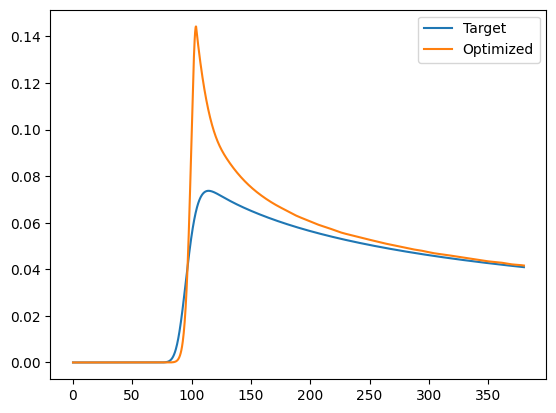

In [5]:
def peak_loss(params, x_vals, target_peak_x, alpha=100.0):
    delta, p, eta = params
    
    # Evaluate function
    y = uniform_asymp(x_vals, alpha=alpha, delta=delta, p=p, eta=eta)
    
    # Find x-value of maximum
    idx_max = np.argmax(y)
    x_peak = x_vals[idx_max]
    
    # Loss: distance between peaks
    return abs(x_peak - target_peak_x)


def loss(params):
    target_peak_x = x_final[np.where(amplitude_final == np.max(amplitude_final))[0][0]]
    delta, p, eta = params
    y_pred = uniform_asymp(x_final, alpha=100.0, delta=delta, p=p, eta=eta)
    return np.sum(abs(y_pred - amplitude_final)) + +0.05*peak_loss(params, x_final, target_peak_x)  # simple L2 loss

# --- Initial guess for parameters ---
init_guess = [1.0, 1.0, 1.0]  # [delta, p, eta]

# --- Run optimization ---
result = scipy.optimize.minimize(loss, init_guess, bounds=[(0, 10), (0.1, 5), (0.1, 100)])
opt_delta, opt_p, opt_eta = result.x

print("Optimal parameters:")
print("delta =", opt_delta)
print("p =", opt_p)
print("eta =", opt_eta)

# --- Plot result ---
y_opt = uniform_asymp(x_final, alpha=100.0, delta=opt_delta, p=opt_p, eta=opt_eta)
plt.plot(x_final, y_opt, label="Target")
plt.plot(x_final, amplitude_final, label="Optimized")
plt.legend()
plt.show()

Optimal parameters for Deaglan's function:
delta = 0.05880870304330003
x_t =  110.51238045113875
ksi =  0.06481082955366206
sigma =  65.52534221455836
A =  -0.9681391163117679
x_pk =  95.37864185521002


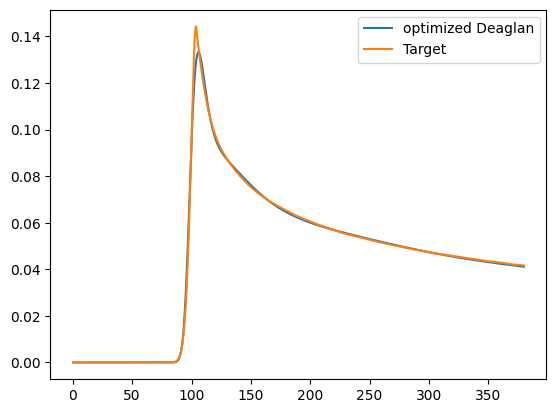

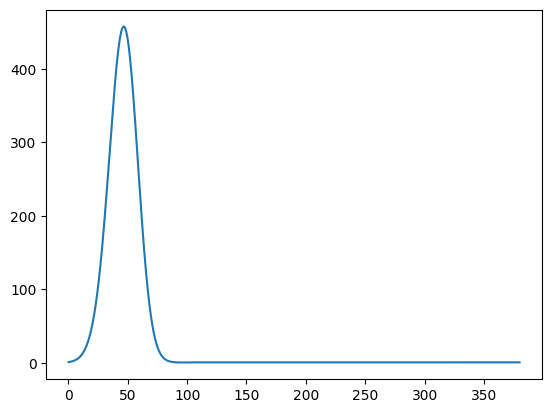

In [6]:
def model_with_peak(x, alpha, delta, ksi, A=0.3, x_pk=100.0, sigma=10.0, x_t=100.0):
    """
    Deaglan envelope model with multiplicative peak correction.
    """
    E = myfun_full(x, alpha=alpha, xt=x_t, delta=delta, ksi=ksi)
    bump = 1.0 + A * np.exp(-0.5 * ((x - x_pk)/sigma)**2)
    return E * bump


def loss(params):
    delta, x_pk, ksi, sigma, A, x_t = params
    #y_pred = myfun_full(x_final, alpha=100.0, xt=x_t, delta=delta, ksi=ksi)
    y_pred = model_with_peak(x_final, alpha=100.0, delta=delta, ksi=ksi, A=A, x_pk=x_pk, sigma=sigma, x_t=x_t)
    return np.sum(abs(y_pred - amplitude_final)) 

# --- Initial guess for parameters ---
init_guess = [0.11, 100,0.3,10.0, 0.3, 100.0]  # [delta, x_pk, ksi, sigma, A, x_t]

# --- Run optimization ---
result = scipy.optimize.minimize(loss, init_guess)
opt_delta, opt_x_pk, opt_ksi, opt_sigma, opt_A, opt_x_t = result.x

print("Optimal parameters for Deaglan's function:")
print("delta =", opt_delta)
print("x_t = ", opt_x_pk)
print("ksi = ", opt_ksi)
print("sigma = ", opt_sigma)
print("A = ", opt_A)
print("x_pk = ", opt_x_t)

# --- Plot result ---
#y_opt = myfun_full(x_final, alpha=100.0, xt = opt_x_t, delta=opt_delta, ksi = opt_ksi)
y_opt = model_with_peak(x_final, alpha=100.0, delta=opt_delta, ksi=opt_ksi, A=opt_A, x_pk=opt_x_pk, sigma=opt_sigma, x_t=opt_x_t)
plt.plot(x_final, y_opt, label="optimized Deaglan")
plt.plot(x_final, amplitude_final, label="Target")
plt.legend()
plt.show()


plt.plot(x_final, amplitude_final / y_opt)
plt.show()


#ratio_deaglan = amplitude_final / myfun_full(x_final, alpha=order, xt=opt_x_t, delta=opt_delta, ksi=opt_ksi)
ratio_deaglan = amplitude_final / y_opt

Optimal parameters for algebraic bump:
delta = 0.17840882856035442
x_pk  = 99.86900586097161
ksi   = 0.22520222305194854
sigma = 6.3174141544271345
A     = 40.41219598564766
x_t   = 79.80291293483921


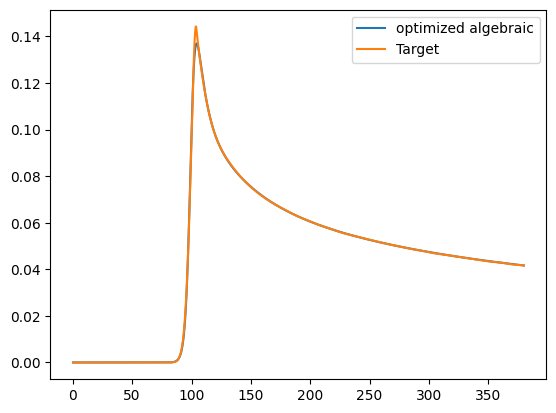

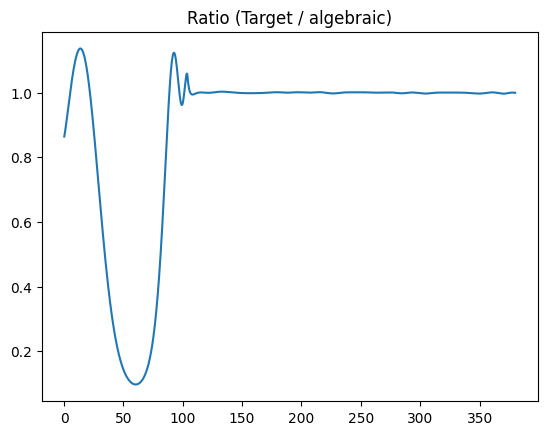

In [7]:

# ------------------------------
# Bump / peak families
# ------------------------------


def gaussian_bump(x, A, x_pk, sigma, **kwargs):
    return 1.0 + A * np.exp(-0.5 * ((x - x_pk) / sigma) ** 2)

def lorentzian_bump(x, A, x_pk, sigma, **kwargs):
    gamma = sigma
    return 1.0 + A / (1.0 + ((x - x_pk) / gamma) ** 2)

def cauchy_bump(x, A, x_pk, sigma, **kwargs):
    gamma = sigma
    return 1.0 + A * gamma**2 / (gamma**2 + (x - x_pk)**2)

def rational_bump(x, A, x_pk, sigma, **kwargs):
    return 1.0 + A / (1.0 + ((x - x_pk) / sigma) ** 4)

def sech_bump(x, A, x_pk, sigma, **kwargs):
    return 1.0 + A * (1.0 / np.cosh((x - x_pk) / sigma))

def logistic_bump(x, A, x_pk, sigma, **kwargs):
    return 1.0 + A * (1.0 / (1.0 + np.exp(-(x - x_pk) / sigma)))

def tanh_bump(x, A, x_pk, sigma, **kwargs):
    return 1.0 + 0.5 * A * (1.0 + np.tanh((x - x_pk) / sigma))

def polynomial_bump(x, A, x_pk, sigma, **kwargs):
    z = (x - x_pk) / sigma
    return 1.0 + A * np.exp(-z**4)

def bump_compact(x, A, x_pk, sigma, **kwargs):
    z = np.abs((x - x_pk) / sigma)
    bump = np.zeros_like(x)
    mask = z < 1
    bump[mask] = A * np.exp(-1.0 / (1 - z[mask] ** 2))
    return 1.0 + bump

def cosine_bump(x, A, x_pk, sigma, **kwargs):
    z = (x - x_pk) / sigma
    bump = np.zeros_like(x)
    mask = np.abs(z) < np.pi/2
    bump[mask] = A * np.cos(z[mask])
    return 1.0 + bump

def exp_power_bump(x, A, x_pk, sigma, power=3, **kwargs):
    return 1.0 + A * np.exp(-np.abs((x - x_pk)/sigma) ** power)


def sinusoidal_mod(x, A, x_pk, sigma, **kwargs):
    """Smooth sinusoidal oscillation around peak region."""
    return 1.0 + A * np.sin((x - x_pk) / sigma) * np.exp(-((x - x_pk)/ (3*sigma))**2)

def damped_osc_mod(x, A, x_pk, sigma, **kwargs):
    """Cosine oscillation with Gaussian damping."""
    return 1.0 + A * np.cos((x - x_pk) / sigma) * np.exp(-0.5*((x - x_pk)/sigma)**2)

def algebraic_mod(x, A, x_pk, sigma, **kwargs):
    """Rational algebraic decay from peak."""
    return 1.0 + A / (1.0 + ((x - x_pk)/sigma)**2)

def plateau_mod(x, A, x_pk, sigma, **kwargs):
    """Flat plateau around x_pk with smooth edges."""
    return 1.0 + A * (np.tanh((x - (x_pk - sigma))/sigma) - np.tanh((x - (x_pk + sigma))/sigma)) / 2

def exp_tail_mod(x, A, x_pk, sigma, **kwargs):
    """Exponential up-down modifier symmetric around x_pk."""
    return 1.0 + A * np.exp(-np.abs(x - x_pk) / sigma)

def double_peak_mod(x, A, x_pk, sigma, **kwargs):
    """Two symmetric Gaussian-like peaks around x_pk."""
    return 1.0 + A * (np.exp(-0.5*((x - (x_pk - sigma))/sigma)**2) +
                      np.exp(-0.5*((x - (x_pk + sigma))/sigma)**2))

def sigmoidal_mod(x, A, x_pk, sigma, **kwargs):
    """Smooth step-up then down (two logistic transitions)."""
    return 1.0 + A * (1/(1+np.exp(-(x - (x_pk - sigma))/sigma)) *
                      (1 - 1/(1+np.exp(-(x - (x_pk + sigma))/sigma))))

def poly_ratio_mod(x, A, x_pk, sigma, **kwargs):
    """Polynomial ratio ~ 1 + A/(1+z^4)."""
    z = (x - x_pk)/sigma
    return 1.0 + A/(1+z**4)


# ---- Dictionary ----
BUMP_FUNCS = {
    "gaussian": gaussian_bump,
    "lorentzian": lorentzian_bump,
    "cauchy": cauchy_bump,
    "rational": rational_bump,
    "sech": sech_bump,
    "logistic": logistic_bump,
    "tanh": tanh_bump,
    "polynomial": polynomial_bump,
    "compact": bump_compact,
    "cosine": cosine_bump,
    "exp_power": exp_power_bump,
}


BUMP_FUNCS.update({
    "sinusoidal": sinusoidal_mod,
    "damped_osc": damped_osc_mod,
    "algebraic": algebraic_mod,
    "plateau": plateau_mod,
    "exp_tail": exp_tail_mod,
    "double_peak": double_peak_mod,
    "sigmoidal": sigmoidal_mod,
    "poly_ratio": poly_ratio_mod,
})

# ------------------------------
# Your model with selectable peak
# ------------------------------

def model_with_peak(x, alpha, delta, ksi,
                    mode="gaussian",
                    A=0.3, x_pk=100.0, sigma=10.0,
                    p=2.0, q=6.0,
                    c1=90.0, c2=110.0, w=5.0, s=5.0,
                    x_t=100.0):
    """
    Deaglan envelope model with multiplicative peak correction.
    `mode` chooses the bump type: "gaussian", "lorentzian", "rational_power", "tanh", "logistic".
    """
    E = myfun_full(x, alpha=alpha, xt=x_t, delta=delta, ksi=ksi)
    bump = BUMP_FUNCS[mode](x, A=A, x_pk=x_pk, sigma=sigma, p=p, q=q,
                            c1=c1, c2=c2, w=w, s=s)
    return E * bump

# ------------------------------
# Loss function for optimization
# ------------------------------

def make_loss(mode):
    def loss(params):
        delta, x_pk, ksi, sigma, A, x_t = params
        y_pred = model_with_peak(x_final, alpha=100.0,
                                 delta=delta, ksi=ksi, mode=mode,
                                 A=A, x_pk=x_pk, sigma=sigma, x_t=x_t)
        return np.sum(abs(y_pred - amplitude_final))
    return loss

# ------------------------------
# Run optimization for one mode
# ------------------------------

mode = "algebraic"  # try: "gaussian", "lorentzian", "tanh", "logistic"

init_guess = [0.11, 100, 0.3, 10.0, 0.3, 100.0]  # [delta, x_pk, ksi, sigma, A, x_t]

result = scipy.optimize.minimize(make_loss(mode), init_guess)
opt_delta, opt_x_pk, opt_ksi, opt_sigma, opt_A, opt_x_t = result.x

print(f"Optimal parameters for {mode} bump:")
print("delta =", opt_delta)
print("x_pk  =", opt_x_pk)
print("ksi   =", opt_ksi)
print("sigma =", opt_sigma)
print("A     =", opt_A)
print("x_t   =", opt_x_t)

# Plot
y_opt = model_with_peak(x_final, alpha=100.0,
                        delta=opt_delta, ksi=opt_ksi, mode=mode,
                        A=opt_A, x_pk=opt_x_pk, sigma=opt_sigma, x_t=opt_x_t)
plt.plot(x_final, y_opt, label=f"optimized {mode}")
plt.plot(x_final, amplitude_final, label="Target")
plt.legend()
plt.show()

plt.plot(x_final, amplitude_final / y_opt)
plt.title(f"Ratio (Target / {mode})")
plt.show()

ratio_deaglan = amplitude_final / y_opt


In [8]:
amplitude_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
}

amplitude_bessel_0 = Problem(f"Amplitude of Bessel (Hilbert decomp) of {order}", (x_amp_sampled,  y_amp_sampled**(1/100)), (x_amp_sampled,  y_amp_sampled**(1/100)), amplitude_bessel_0_args)

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 train'}, xlabel='X-axis', ylabel='Y-axis'>

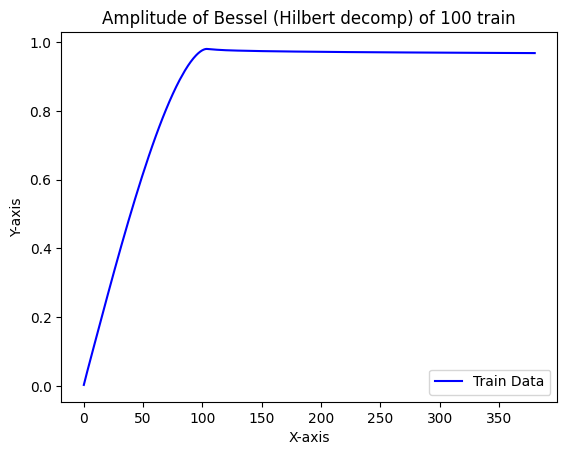

In [9]:
amplitude_bessel_0.plot_data()

In [ ]:
amplitude_bessel_0.solve()

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

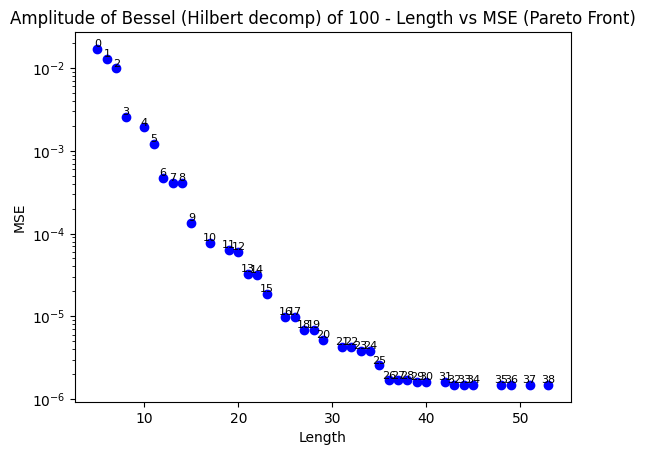

In [ ]:
amplitude_bessel_0.plot_l_vs_mse()

X1*b0/(X1**6*b1 + X1*b2 + b3) + b4 - b5/(X1**6*b1 + X1*b2 + b3)


<IPython.core.display.Math object>

{'b0': 0.05990202333347838,
 'b1': 2.0919910139103426e-11,
 'b2': 0.03234477713699846,
 'b3': 5.950335502625421,
 'b4': 0.9642497897150406,
 'b5': 5.797291601894358}

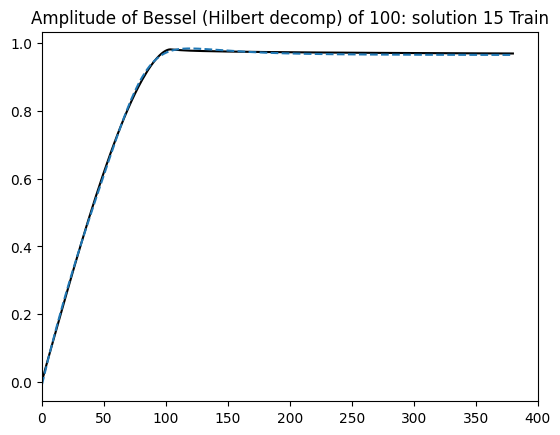

In [ ]:
c_amp = 15
x_data = np.linspace(10**(-20), 400, 500)

print(str(amplitude_bessel_0.solutions[c_amp].sympy_expr))
amplitude_bessel_0.solutions[c_amp].plot_results()

# plt.plot(x_data, np.log(1/special.gamma(1+order)*(1/2)**order) + 100*np.log(x_data))
# plt.plot(x_data, np.log(np.sqrt(2/np.pi)) - 1/2*np.log(x_data))


plt.xlim(0, 400)
amplitude_bessel_0.solutions[c_amp].display_expression()
amplitude_bessel_0.solutions[c_amp].b_vals

In [ ]:
candidate_str_ampl = 'X1*b0/(X1**6*b1 + X1*b2 + b3) + 1 - b5/(X1**6*b1 + X1*b2 + b3)'

Candidate_ampl = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str_ampl), (x_amp_sampled, np.log(y_amp_sampled)), amplitude_bessel_0.solutions[c_amp], amplitude_bessel_0.solutions[c_amp].b_vals)

In [ ]:
# manual_expression_string = "b1*sqrt(b2)/(b5)"
# manual_target_value =  np.sqrt(2/np.pi)
# num_params = len(amplitude_bessel_0.solutions[c_amp].b_vals)
# full_param_symbols = [sp.Symbol(f'b{i}') for i in range(num_params-1)]

# parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
# constraints_man = []
# constraints_man.append(parameter_limit_inf_constraint)

#Candidate_ampl.optimisation(constraints_eq=constraints_man)
Candidate_ampl.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 196, CG iterations: 27, optimality: 1.87e+11, constraint violation: 0.00e+00, execution time: 0.025 s.

Optimization summary:
Parameter | Old Value   | New Value   | Abs Difference
--------- | ---------   | ---------   | --------------
b0        | 0.059902    | 0.059902    | 0             
b1        | 2.09199e-11 | 2.09199e-11 | 0             
b2        | 0.0323448   | 0.0323448   | 0             
b3        | 5.95034     | 5.95034     | 0             
b4        | 0.96425     | 0.96425     | 0             
b5        | 5.79729     | 5.79729     | 0             



(0.0599020233334784*X1/(2.09199101391034e-11*X1**6 + 0.0323447771369985*X1 + 5.95033550262542) + 0.964249789715041 - 5.79729160189436/(2.09199101391034e-11*X1**6 + 0.0323447771369985*X1 + 5.95033550262542),
 {'b0': np.float64(0.05990202333347838),
  'b1': np.float64(2.0919910139103426e-11),
  'b2': np.float64(0.03234477713699846),
  'b3': np.float64(5.950335502625421),
  'b4': np.float64(0.9642497897150406),
  'b5': np.float64(5.797291601894358)},
 {'b0': np.float64(0.0),
  'b1': np.float64(0.0),
  'b2': np.float64(0.0),
  'b3': np.float64(0.0),
  'b4': np.float64(0.0),
  'b5': np.float64(0.0)},
 np.float64(681473.038734183))

(-0.5, 2.0)

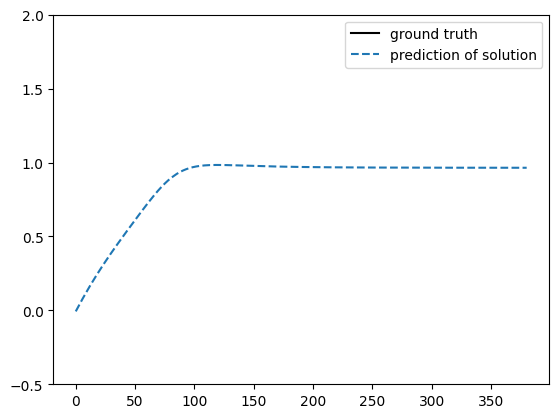

In [ ]:
x_data = np.linspace(0, 200, 500)

#Candidate_ampl.plot_comparison(x_data, np.sqrt(2/(np.pi*x_data)))
Candidate_ampl.plot_comparison()
plt.ylim(-0.5, 2.0)

In [ ]:
phase_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
}

phase_bessel_0 = Problem(f"Phase of Bessel (Hilbert decomp) of {order}", (x_phase_sampled, y_phase_sampled), (x_phase_sampled, y_phase_sampled), phase_bessel_0_args)

<Axes: title={'center': 'Phase of Bessel (Hilbert decomp) of 100 train'}, xlabel='X-axis', ylabel='Y-axis'>

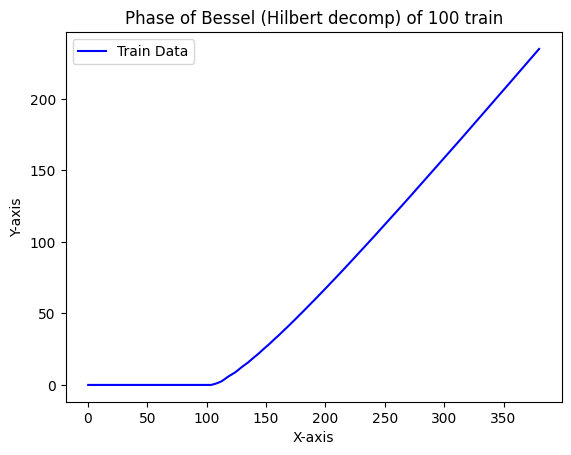

In [ ]:
phase_bessel_0.plot_data()

In [ ]:
phase_bessel_0.solve()

[8.977542877197266, 5.0], 10459.61, ((-97.736663818359) + ((-0.232558950782) * ((-3.672310829163) * X1))), 80.60
[7.084219455718994, 7.0], 6622.00, ((-8.349789619446) + (0.086903996766 * (((-0.024162292480) * X1) * ((-0.854180157185) * X1)))), 50.19
[4.896465301513672, 9.0], 3322.83, ((-45.771469116211) + (0.152935937047 * ((((-0.008223684505) * X1) * ((-0.854180157185) * X1)) - ((-2.282474040985) * X1)))), 23.98
[1.7305411100387573, 11.0], 681.38, (7.280385494232 + (2.736865043640 * ((0.406658798456 * X1) + (((-1.311987400055) * X1) / (1.483126878738 - ((-0.014655590057) * X1)))))), 2.99
[0.8801630139350891, 13.0], 407.56, (4.188034534454 + (1.957889914513 * ((0.408407300711 * X1) + (((-1.169039964676) * X1) / (1.997960925102 + (((-0.008223684505) * X1) * ((-0.008223684505) * X1))))))), 0.77
[0.5796506404876709, 15.0], 364.01, ((-0.285310715437) + ((-0.242650300264) * (((((-0.126534119248) * X1) * ((-0.564740419388) * X1)) / (0.513064861298 + (((-0.008223684505) * X1) * ((-0.014655590

<Axes: title={'center': 'Phase of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

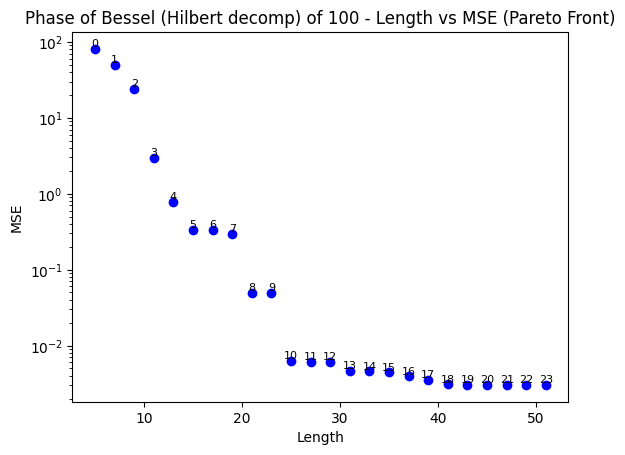

In [ ]:
phase_bessel_0.plot_l_vs_mse()

-X1**2*b0/(X1**2*b1 - X1*b2/(X1*b3 - b4 + b5/X1) + b6) + X1*b7 - X1*b8/(-X1*b10 + b9) - b11 + b12/(X1**2*b13 - X1*b14 + b15) + b16/(-X1*b10 + b17)


<IPython.core.display.Math object>

{'b0': 0.01684032924760359,
 'b1': 0.00012052294886338855,
 'b2': 0.00822368450499944,
 'b3': 1.1483634561300278,
 'b4': 6.252403083039098,
 'b5': 439.6224284108612,
 'b6': 0.4575432538990185,
 'b7': 0.976488279333239,
 'b8': 0.0003503807692911143,
 'b9': 1.4946607351300827,
 'b10': 0.014655590057000012,
 'b11': 0.3714264333249844,
 'b12': 0.19529397282303762,
 'b13': 0.000214786319918836,
 'b14': 0.034002989328307365,
 'b15': 1.342257398642687,
 'b16': 0.3332798445990761,
 'b17': 6.163349628447577}

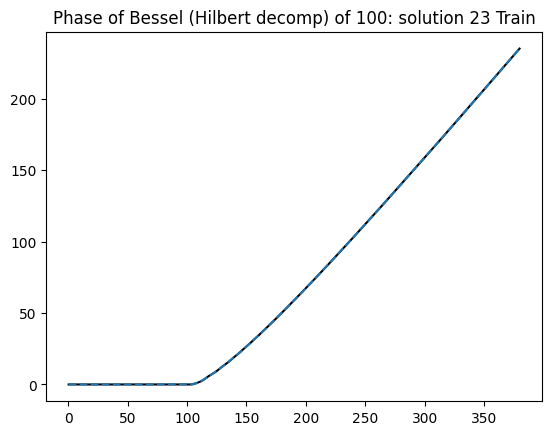

In [ ]:
c_phi = -1
print(str(phase_bessel_0.solutions[c_phi].sympy_expr))
phase_bessel_0.solutions[c_phi].plot_results()
phase_bessel_0.solutions[c_phi].display_expression()
phase_bessel_0.solutions[c_phi].b_vals


In [ ]:
#candidate_str = f'X1 - ({order}*pi/2+pi/4) - b2/(X1*b3 + X1*b4/(X1*b5 - b6) + X1*b7/(-X1*b9 + b8) - b10/(-X1*b9 + b11)) + b12/X1'
candidate_str = '-X1**2*b0/(X1**2*b1 - X1*b2/(X1*b3 - b4 + b5/X1) + b6) + X1*b7 - X1*b8/(-X1*b10 + b9) - b11 + b12/(X1**2*b13 - X1*b14 + b15) + b16/(-X1*b10 + b17)'

Candidate_phase = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str), (x_phase_sampled, y_phase_sampled), phase_bessel_0.solutions[c_phi], phase_bessel_0.solutions[c_phi].b_vals)

In [ ]:
manual_expression_string = "-b1 + b2/b11"
manual_target_value =  0.0
full_param_symbols = [sp.Symbol(f'b{i}') for i in range(len(phase_bessel_0.solutions[c_phi].b_vals)-2)]

parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
constraints_man = []
constraints_man.append(parameter_limit_inf_constraint)

Candidate_phase.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 76, function evaluations: 684, CG iterations: 194, optimality: 1.05e+07, constraint violation: 0.00e+00, execution time: 0.088 s.

Optimization summary:
Parameter | Old Value   | New Value   | Abs Difference
--------- | ---------   | ---------   | --------------
b0        | 0.0169021   | 0.0138046   | 0.00309747    
b1        | 0.000120523 | 9.27652e-05 | 2.77577e-05   
b2        | 0.457543    | 0.457358    | 0.000184854   
b4        | 0.525943    | 0.525952    | 9.66933e-06   
b5        | 0.235464    | 0.235449    | 1.42724e-05   
b6        | 0.000214786 | 0.000325855 | 0.000111068   
b7        | 0.0347061   | 0.0346863   | 1.98309e-05   
b8        | 1.39507     | 1.39518     | 0.000103119   



(-0.0138045923308377*X1**2/(9.27652244964502e-5*X1**2 + 0.457358399548642) + X1 - 0.525952233337986 + 0.235449316039552/(0.00032585476122654*X1**2 - 0.0346862613305361*X1 + 1.39517563225538),
 {'b0': np.float64(0.013804592330837712),
  'b1': np.float64(9.276522449645015e-05),
  'b2': np.float64(0.4573583995486425),
  'b4': np.float64(0.5259522333379861),
  'b5': np.float64(0.23544931603955158),
  'b6': np.float64(0.0003258547612265401),
  'b7': np.float64(0.03468626133053614),
  'b8': np.float64(1.3951756322553754)},
 {'b0': np.float64(0.003097474176830966),
  'b1': np.float64(2.7757724366938392e-05),
  'b2': np.float64(0.00018485435037601805),
  'b4': np.float64(9.669327024952601e-06),
  'b5': np.float64(1.4272392048070293e-05),
  'b6': np.float64(0.00011106844130770411),
  'b7': np.float64(1.983085880259e-05),
  'b8': np.float64(0.00010311862685541406)},
 np.float64(16241.804027282957))

-X1**2*b0/(X1**2*b1 + b2) + X1 - b4 + b5/(X1**2*b6 - X1*b7 + b8)

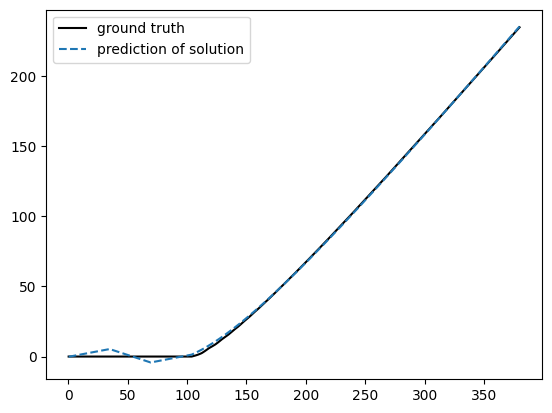

In [ ]:

#Candidate_phase.plot_comparison(x_data, y_data=x_data-order*np.pi/2-np.pi/4)
Candidate_phase.plot_comparison()
Candidate_phase.sympy_expr

Overall Mean Squared Error (MSE): 9.459824e-04


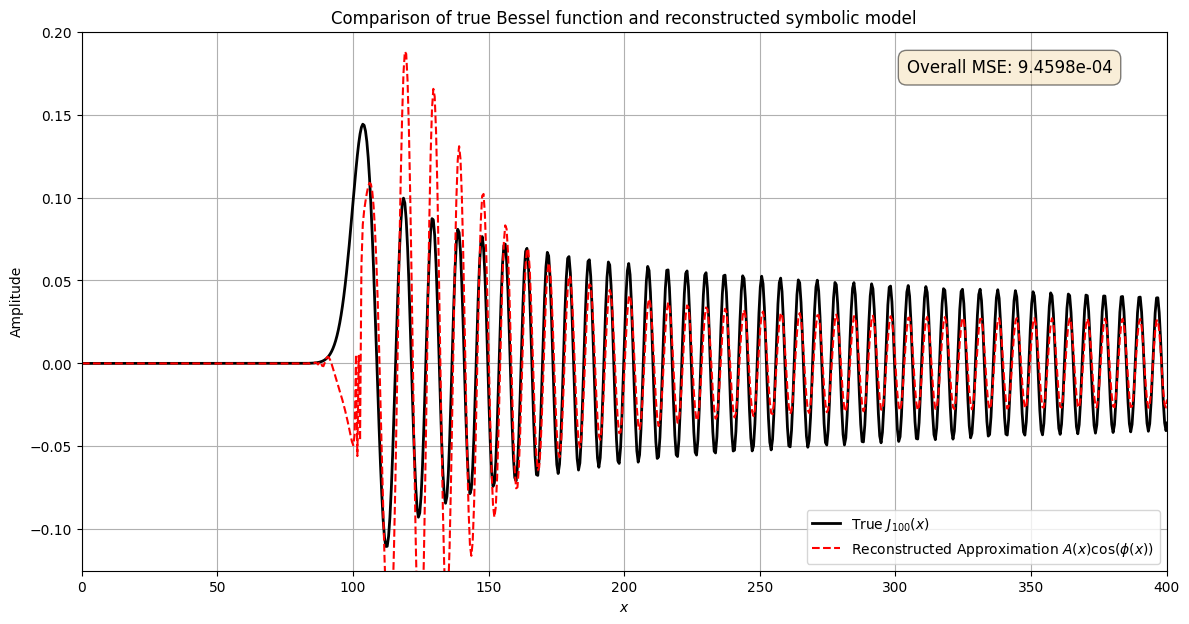

In [ ]:
def calculate_mse(y_true, y_pred):
    return np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)
# 1. Define the symbolic variable
X1 = sp.Symbol('X1')

# 2. Extract the solution objects
# amp_solution = amplitude_bessel_0.solutions[4]
# phase_solution = phase_bessel_0.solutions[10]

amp_solution = Candidate_ampl
phase_solution = Candidate_phase


# 3. Get the symbolic expressions
A_expr = amp_solution.sympy_expr
phi_expr = phase_solution.sympy_expr

# --- STEP 1: SUBSTITUTE NUMERICAL CONSTANTS ---
# This is the critical new step.
# NOTE: You might need to change '.params' to the correct attribute name 
# that holds the dictionary of constant values (e.g., .constants_).
# A_numeric_expr = A_expr.subs(amp_solution.b_vals)
# phi_numeric_expr = phi_expr.subs(phase_solution.b_vals)

A_numeric_expr = A_expr.subs(amp_solution.modified_parameters)
phi_numeric_expr = phi_expr.subs(phase_solution.modified_parameters)

# 4. Combine the now-numeric expressions
bessel_approx_expr = (A_numeric_expr**100) * sp.cos(phi_numeric_expr)

# print("--- Final Expression with Numerical Constants ---")
# print(bessel_approx_expr)
# print("-" * 50)

# 5. Lambdify the final expression
# This now works because the only symbol left is X1.
# We keep the modules fix to be safe.
f_bessel_approx = sp.lambdify(
    (X1,), 
    bessel_approx_expr, 
    modules=[{'sqrt': np.sqrt}, 'numpy']
)

# 6. Generate data and plot (same as before)
x_data = np.linspace(10**(-1), 1000, 2000)
y_true = special.jv(order, x_data)

# This call will now succeed.
y_pred = f_bessel_approx(x_data) #* model_with_peak(x_data, alpha=100.0, delta=opt_delta, ksi=opt_ksi, A=opt_A, x_pk=opt_x_pk, sigma=opt_sigma, x_t=opt_x_t) #* myfun_full(x_data, alpha=order, xt=opt_x_t, delta=opt_delta, ksi=opt_ksi)


# Assuming y_true and y_pred have been calculated
overall_mse = calculate_mse(y_true, y_pred)

print(f"Overall Mean Squared Error (MSE): {overall_mse:.6e}")


# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(14, 7))

# Use the 'ax' object for all plotting commands
ax.plot(x_data, y_true, label=f'True $J_{{{order}}}(x)$', color='black', linewidth=2)
ax.plot(x_data, y_pred, label=r'Reconstructed Approximation $A(x) \cos(\phi(x)) $', color='red', linestyle='--')

# Set titles and labels on the axes object
ax.set_title('Comparison of true Bessel function and reconstructed symbolic model')
ax.set_xlabel('$x$')
ax.set_ylabel('Amplitude') # Added a Y-axis label for completeness
ax.legend()
ax.grid(True)

# The ax.text call will now work correctly
# (Assuming overall_mse is already calculated)
mse_text = f"Overall MSE: {overall_mse:.4e}"
ax.text(0.95, 0.95, mse_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.ylim(-1/8, 1/5)
plt.xlim(0, 400)
plt.show()

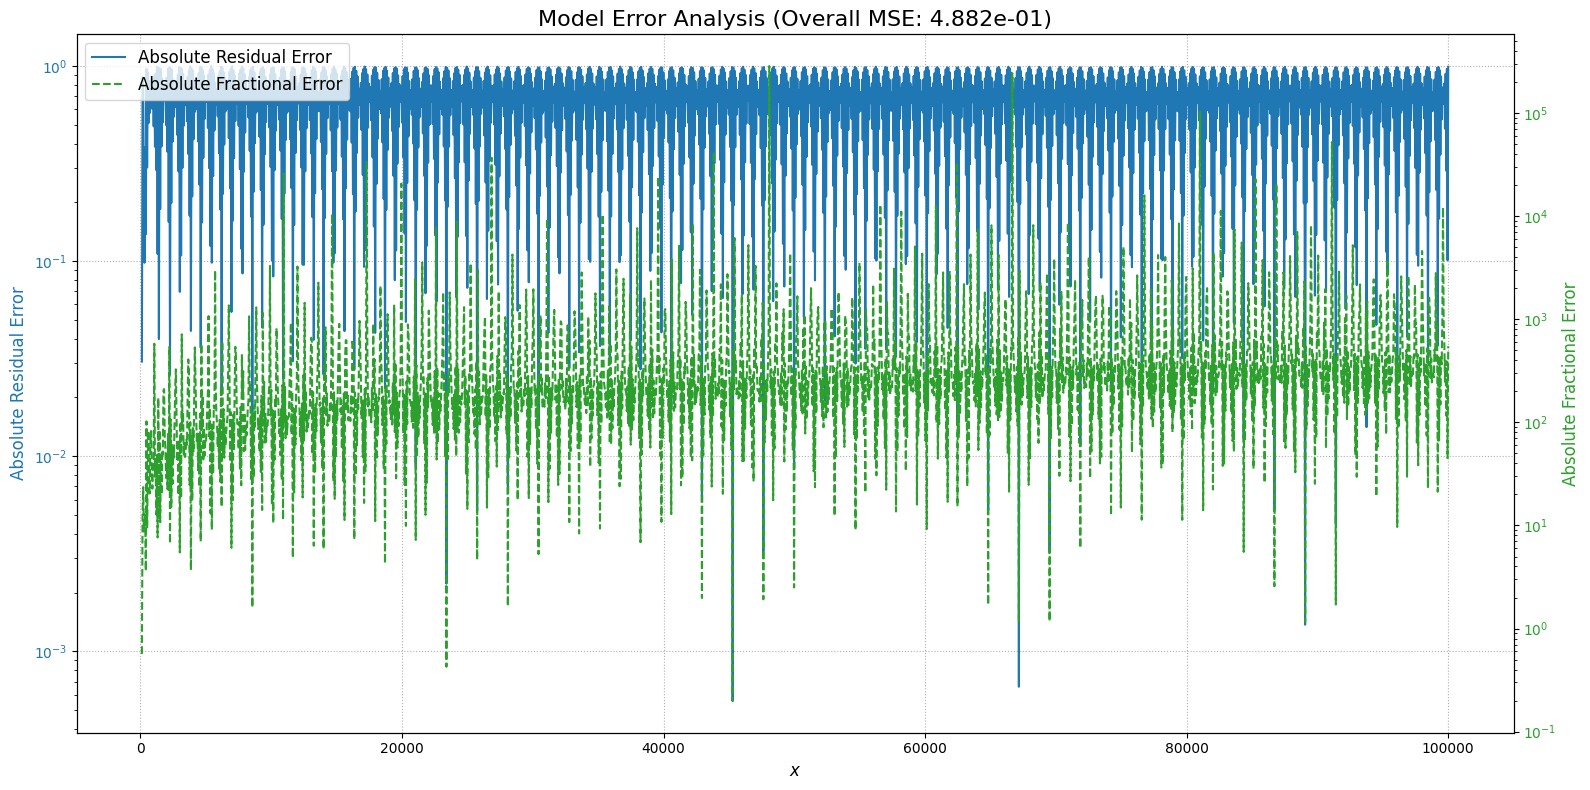

In [ ]:
# Assume your calculate_mse function is defined elsewhere in your notebook


def plot_error_analysis(amp_candidate, phase_candidate, order_val, 
                        x_range=(110, 100000), num_points=2000,
                        plot_residual_abs=True, plot_fractional=True):
    """
    Generates a focused plot of the model's error, with options to show
    absolute residual error and/or fractional error.

    Args:
        amp_candidate: Your fitted candidate object for the amplitude.
        phase_candidate: Your fitted candidate object for the phase.
        order_val (int): The order of the Bessel function for the true data.
        x_range (tuple): The (start, end) of the x-axis for plotting.
        num_points (int): The number of points to generate for the plot.
        plot_residual_abs (bool): If True, plots the absolute residual error.
        plot_fractional (bool): If True, plots the absolute fractional error.
    """
    if not plot_residual_abs and not plot_fractional:
        print("No plots requested. Set 'plot_residual_abs' or 'plot_fractional' to True.")
        return

    X1 = sp.Symbol('X1')

    # 1. Prepare and lambdify the symbolic model
    A_expr = amp_candidate.sympy_expr.subs(amp_candidate.modified_parameters)
    phi_expr = phase_candidate.sympy_expr.subs(phase_candidate.modified_parameters)
    bessel_approx_expr = A_expr * sp.cos(phi_expr)
    f_bessel_approx = sp.lambdify((X1,), bessel_approx_expr, modules=['numpy'])

    # 2. Generate data
    x_data = np.linspace(x_range[0], x_range[1], num_points)
    y_true = special.jv(order_val, x_data)
    y_pred = f_bessel_approx(x_data)

    # 3. Calculate error metrics
    mse = calculate_mse(y_true, y_pred)
    residuals = y_true - y_pred
    absolute_residual_error = np.abs(residuals)
    
    epsilon = 1e-12 
    fractional_error = residuals / (np.abs(y_true) + epsilon)
    absolute_fractional_error = np.abs(fractional_error)

    # 4. Create the visualization based on flags
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1.set_title(f"Model Error Analysis (Overall MSE: {mse:.3e})", fontsize=16)
    ax1.set_xlabel('$x$', fontsize=12)
    ax1.grid(True, linestyle=':')

    # Case 1: Plot both using a twin axis
    if plot_residual_abs and plot_fractional:
        ax2 = ax1.twinx()
        line1 = ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.set_yscale("log")

        line2 = ax2.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax2.set_ylabel('Absolute Fractional Error', color='#2ca02c', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#2ca02c')
        ax2.set_yscale("log")
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=12)

    # Case 2: Plot only the absolute residual error
    elif plot_residual_abs:
        ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    # Case 3: Plot only the fractional error
    elif plot_fractional:
        ax1.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax1.set_ylabel('Absolute Fractional Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    plt.show()

# --- HOW TO USE THE FUNCTION ---
# This cell should be run AFTER your cell where 'Candidate_ampl', 
# 'Candidate_phase', and 'order' are defined.

# Example 1: Plot both (default behavior)
# plot_error_analysis(Candidate_ampl, Candidate_phase, order)

# Example 2: Plot only the absolute residual error
# plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_fractional=False)

# Example 3: Plot only the absolute fractional error
plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_residual_abs=True)